### Step 1: Prediction Task

In [1]:
# Start by importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from sklearn.svm import SVC



In [2]:
# Read in the train and test csv files
df_train = pd.read_csv('au_train.csv')
df_test = pd.read_csv('au_test.csv')

In [3]:
# Most of this information is already given/assumed in the prompt, however it is good practice to explore the
# dataset and look for things like missing values, dtypes and shape in order to make good decisions  
# moving forward. This can be further explored with things like .describe(), .shape, .isnull() etc.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  class           32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [4]:
# Checking to see if the dataset is balanced for the target variable
df_train['class'].value_counts()

 <=50K    24720
 >50K      7841
Name: class, dtype: int64

The dataset seems to have an abundant amount of <=50K so I am going to implement an over-sampling method called SMOTENC (which can handle categorical and numeric data) and an under-sampling method of randomly deleting columns to balance the data and compare each method with the original to see if either method makes a significant difference.

In [5]:
# under-sampling dataset
# creating a dataframe with just rows that contain <=50K
majority = df_train[df_train['class'].str.contains("<=50K")]
# randomly selecting 16879 rows to delete from the majority
majority_drop = majority.sample(n=16879, replace = False)
df_undersample = df_train.copy()

# dropping the randomly selected samples to create the under-sample dataframe
for x in majority_drop.index:
     df_undersample = df_undersample.drop([x], axis = 0)
        
# df_undersample.shape
# df_undersample['class'].value_counts()

In [6]:
# convert categorical variables to numeric to use in ML model
df_numeric_train = df_train.copy()
df_numeric_test = df_test.copy()

cols = list(df_numeric_train.columns)
for col in cols:
    if str(df_numeric_train[col].dtype) == 'object':
        df_numeric_train[col] = df_numeric_train[col].astype('category').cat.codes
    if str(df_numeric_test[col].dtype) == 'object':
        df_numeric_test[col] = df_numeric_test[col].astype('category').cat.codes
    if str(df_undersample[col].dtype) == 'object':
        df_undersample[col] = df_undersample[col].astype('category').cat.codes

#df_numeric_train.head()

In [7]:
#Create X and Y variables for the train and test set
X_train = df_numeric_train.loc[:, df_numeric_train.columns != 'class']
y_train = df_numeric_train['class']
X_test = df_numeric_test.loc[:, df_numeric_test.columns != 'class']
y_test = df_numeric_test['class']

#Create X and y for under-sampled test df
X_undersample = df_undersample.loc[:, df_undersample.columns != 'class']
y_undersample = df_undersample['class']

In [8]:
#SMOTE using imblearn library
sm = SMOTENC(categorical_features=[1, 3, 5, 6, 7, 8, 9, 13], random_state=42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

Now that all of the data is prepared I will use a Random Forest Classifier. I chose this model because it can perform both regression and classification tasks. It can handle large data sets and has an overall higher level of accuracy in predicting outcomes as compared to other models. 

To choose the optimal parameters to use for this model I will use randomsearchCV:

In [9]:
#This is an expensive process so this cell was run previously to gather parameters and then commented out
'''#use randomsearchCV to find best parameters to use
clf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

grid_values = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
 }

rand_search_clf = RandomizedSearchCV(estimator = clf, param_distributions = grid_values, n_iter = 10, cv = 3, verbose=2, scoring='f1_macro', random_state= 42, n_jobs = -1)

my_list = list(range(100))
for x in tqdm(my_list):
    rand_search_clf.fit(X_train[0:10000], y_train[0:10000])
print(rand_search_clf.best_estimator_)'''


"#use randomsearchCV to find best parameters to use\nclf = RandomForestClassifier(random_state=42).fit(X_train, y_train)\n\ngrid_values = {'bootstrap': [True, False],\n 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],\n 'min_samples_leaf': [1, 2, 4],\n 'min_samples_split': [2, 5, 10],\n 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]\n }\n\nrand_search_clf = RandomizedSearchCV(estimator = clf, param_distributions = grid_values, n_iter = 10, cv = 3, verbose=2, scoring='f1_macro', random_state= 42, n_jobs = -1)\n\nmy_list = list(range(100))\nfor x in tqdm(my_list):\n    rand_search_clf.fit(X_train[0:10000], y_train[0:10000])\nprint(rand_search_clf.best_estimator_)"

In [10]:
# initilize machine learning model with best parameters
clf = RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=400,
                       random_state=42)

In [11]:
# fit model on original dataset
originaldata = clf.fit(X_train, y_train)

# fit model on smote dataset
smotedata = clf.fit(X_smote, y_smote)

#fit model on under-sampled dataset
undersample = clf.fit(X_undersample, y_undersample)

In [12]:
# accuracy scores original
results = (originaldata.score(X_train, y_train),originaldata.score(X_test, y_test)) 
print(results)

# accuracy scores smote
results2 = (smotedata.score(X_smote, y_smote),smotedata.score(X_test, y_test)) 
print(results2)

# accuracy scores under-sampled
results3 = (undersample.score(X_undersample, y_undersample),undersample.score(X_test, y_test)) 
print(results3)

(0.85734467614631, 0.809225477550519)
(0.8897653721682848, 0.809225477550519)
(0.9203545466139523, 0.809225477550519)


In [13]:
clf = RandomForestClassifier()
testing = clf.fit(X_train, y_train)
result = (testing.score(X_train, y_train),testing.score(X_test, y_test)) 
result



(0.9999078652375541, 0.8556599717462072)

Neither of the sampling methods for balancing the data seemed to make a difference on the accuracy of the model. Continuing on I will only be using the original dataset.

In [14]:
#functions to get extra model scores quickly
def get_performance_scores(y_pred, y_true):
    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    return [f1, precision, recall]

def print_performance_scores(scores):
    print("Precision Score = " + str(scores[1]))
    print("Recall Score = " + str(scores[2]))
    print("F1 Score = " + str(scores[0]))

In [15]:
# class probabilities with original data
prob_original = originaldata.predict_proba(X_test)

prob_test = testing.predict_proba(X_test)

In [16]:
# AUROC curve original data
# This measurement will tell us how well the model is able to differentiate between classes
fpr, tpr, thresh = roc_curve(y_test, prob_original[:,1], pos_label=1)
auc_score1 = roc_auc_score(y_test, prob_original[:,1])
print("AUROC CURVE = " + str(auc_score1))

AUROC CURVE = 0.9132176762744012


<AxesSubplot:>

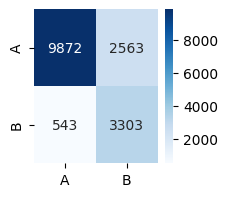

In [17]:
#creating the confusion matrix
y_pred = originaldata.predict(X_test)
cm = confusion_matrix(y_test,y_pred)

#plotting the confusion matrix
df_cm = pd.DataFrame(cm, index = [i for i in "AB"],
                  columns = [i for i in "AB"])
plt.figure(figsize = (2,2))
sns.heatmap(df_cm, annot=True, fmt='.0f', cmap = "Blues") 

# From the confusion matrix we can see that the model does a pretty good job at predicting true positives and negatives

In [18]:
# extra ways of measuring model performance
print_performance_scores(get_performance_scores(y_pred, y_test))

# The precision score tells us how many positive predictions were correct out of all of the positive predictions
# The Recall score tells us how well the model predicted positives out of the true positives
# The F1 score is basically the mean of the precision and recall scores

Precision Score = 0.7554695038284203
Recall Score = 0.8263512856557689
F1 Score = 0.7721297391122535


### Step 2: Segmentation Study

In [19]:
# I'm now using .describe() to get more insight on the numeric variables in the original train dataset
df_train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


I can see that the age ranges from 17-90 and the average age is around 38 years old. 
I can see that the hours worked per week ranges from 1-99 and the average is around 40. Its interesting to see that the average years of education in this dataset is only 10 years.

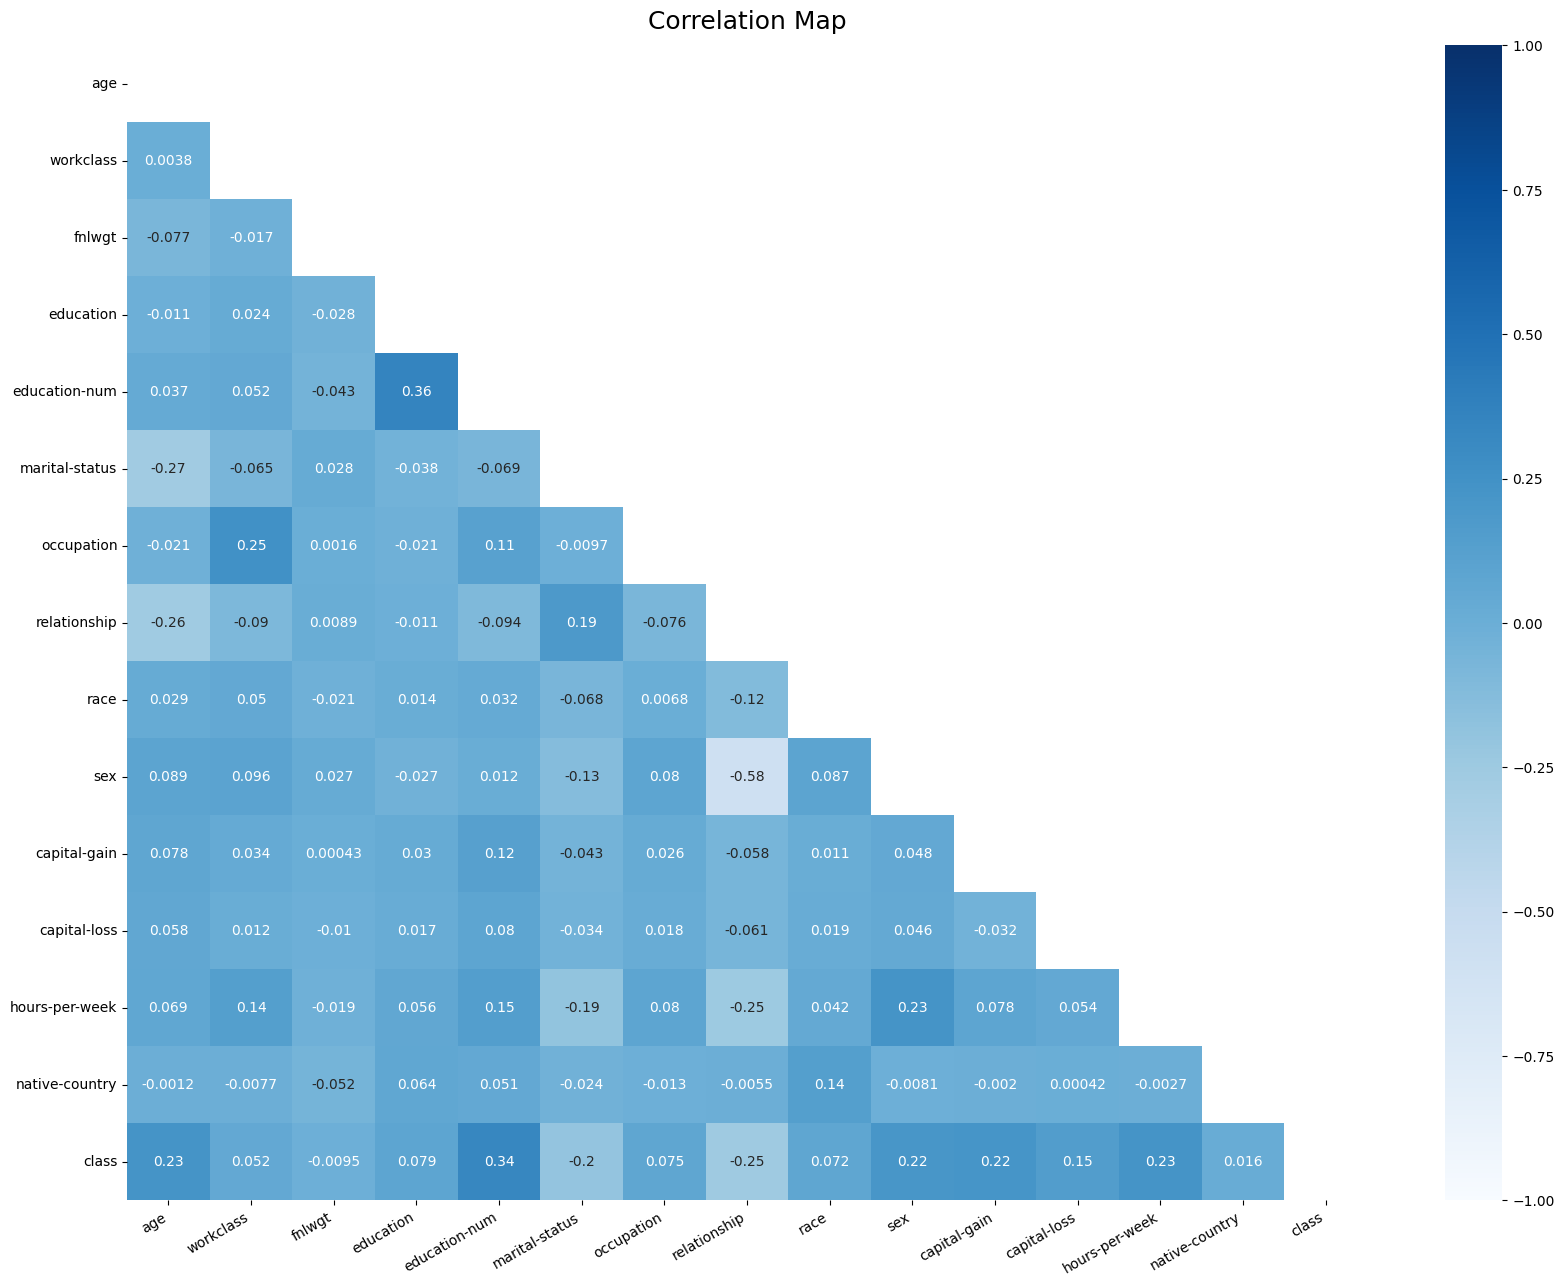

In [20]:
# Creating a heatmap to explore the correlations between variables with seaborn 
mask = np.triu(np.ones_like(df_numeric_train.corr(), dtype=np.bool_))
plt.figure(figsize=(20, 15))
heatmap = sns.heatmap(df_numeric_train.corr(), mask = mask, vmin=-1, vmax=1, annot=True, cmap = "Blues")
heatmap.set_title('Correlation Map', fontdict={'fontsize':18}, pad=12);
plt.xticks(rotation=30, horizontalalignment='right')
plt.show()

The chart above gives me a lot of insight into all of the different variables. I am focused on finding information that relates to the class variable. To find out which varaibles correlate with the class variable I will create a correlation matrix. This will give me more direction on where to focus my attention during the segmentation study. 

In [21]:
# Create correlation matrix to find which features are most correlated to class
df_corr = df_numeric_train.corrwith(df_numeric_train["class"])
df_corr = df_corr.abs()
df_corr.sort_values(inplace=True, ascending=False)
df_corr

class             1.000000
education-num     0.335154
relationship      0.250918
age               0.234037
hours-per-week    0.229689
capital-gain      0.223329
sex               0.215980
marital-status    0.199307
capital-loss      0.150526
education         0.079317
occupation        0.075468
race              0.071846
workclass         0.051604
native-country    0.015840
fnlwgt            0.009463
dtype: float64

I can see that the variables that correlate the most with class are education-num, relationship and age. I will make sure to focus some attention to these variables during the segmentation study.

The next step I want to take is identifying groups within the data using kmeans clustering:

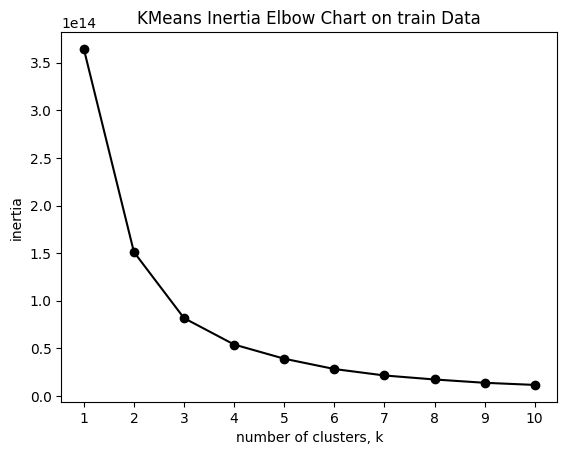

In [22]:
# To find the best number of clusters to use in kmeans I will create an elbow chart using Matplotlib
ks = range(1,11) #Set Range for Looping to 10
inertia = [] #Initiate Inertia List

for k in ks:
    model = KMeans(n_clusters = k)
    model.fit(X_train) 
    inertia.append(model.inertia_) 

#Plot Cluster Elbow Chart using matplotlib
plt.plot(ks, inertia, '-o', color='black') 
plt.xlabel('number of clusters, k') 
plt.ylabel('inertia') 
plt.title('KMeans Inertia Elbow Chart on train Data') 
plt.xticks(ks) 
plt.show() 

In [23]:
# Use kmeans to predict which cluster each person fits into
au_km = KMeans(n_clusters=3)
au_km.fit(X_train) 
au_predict = au_km.predict(X_train) 
au_predict

array([2, 2, 0, ..., 0, 0, 0], dtype=int32)

In [24]:
# add a new column called cluster to the dataset
df_train['cluster'] = pd.Series(au_predict, index=df_train.index) 
df_train.head() 

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class,cluster
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,2
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,2
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,1


In [25]:
# INTERPRET
cluster_groups = df_train.groupby(['cluster']).mean().reset_index()
cluster_groups

#Change cluster column to categorical for plotting
df_train['cluster'] = df_train['cluster'].astype('category')

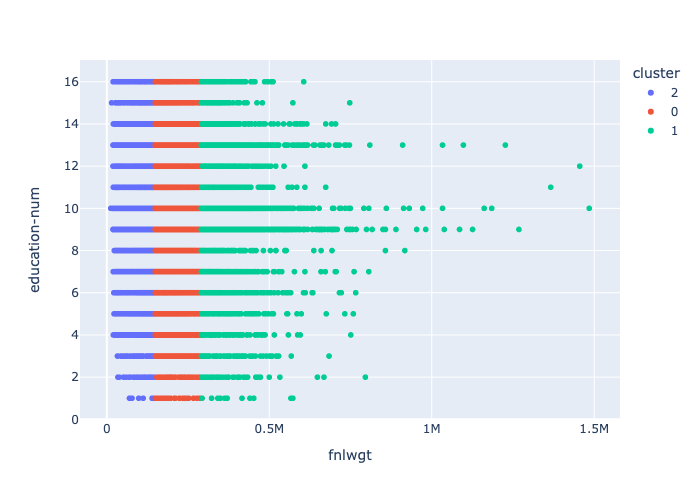

In [34]:
#Now I will use plotly for the remainder of the segmentation study.
fig1 = px.scatter(df_train, x="fnlwgt", y="education-num", color = 'cluster')
fig1.show("png")

The kmeans model clustered the groups mostly based on fnlwgt. It was hard to see any clear clustering happening when vizualizing any of the other variables. 

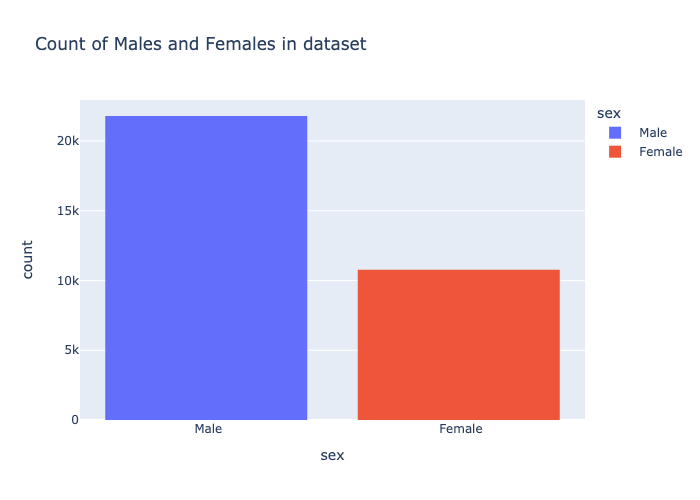

In [35]:
# Distribution of Age
#px.histogram(df_train, x="sex", color="class")
fig2 = px.histogram(df_train, x="sex", color = "sex", title = 'Count of Males and Females in dataset')
fig2.show("png")

The are more males than females suggesting the customer base of this company is more so male than female

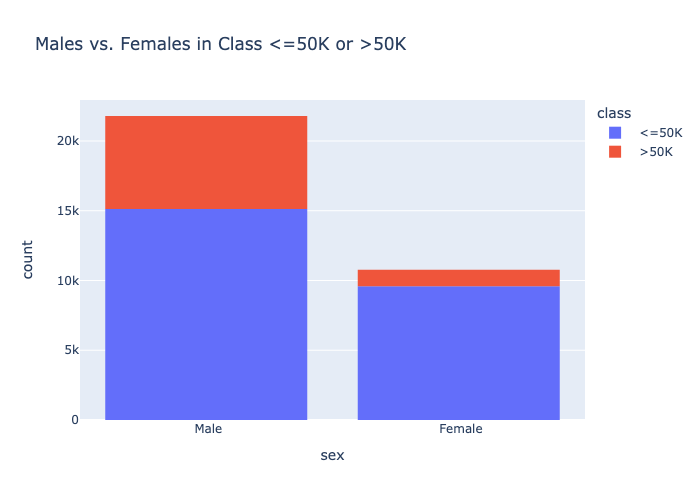

In [36]:
fig3 = px.histogram(df_train, x="sex", color="class", title = 'Males vs. Females in Class <=50K or >50K')
fig3.show("png")

It looks like there is a trend where more males than females make >50K.

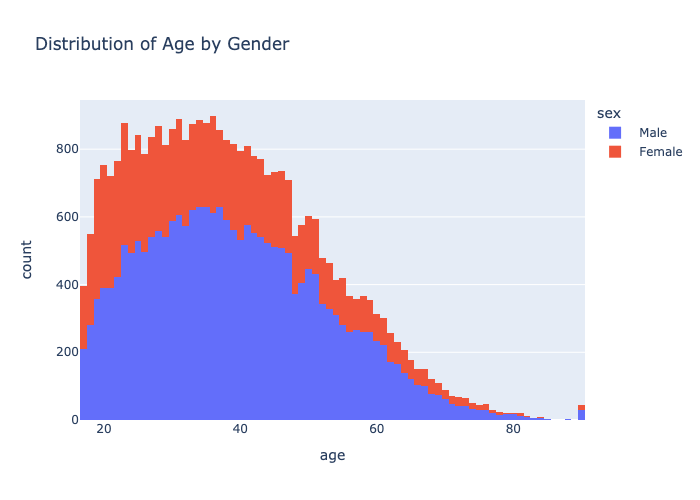

In [37]:
#distribution of age by gender
fig4 = px.histogram(df_train, x="age", color="sex", title = 'Distribution of Age by Gender')
fig4.show("png")

The distribution of males and females across ages is similar. It seems that the majority of the data is from people who are between 20 and 50 which makes sense given the desritpive statistics showed an average age of around 40. 

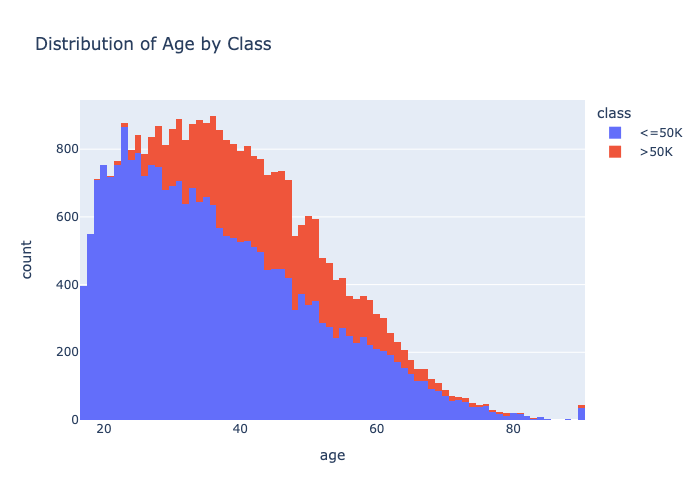

In [41]:
# Distribution of age
fig5 = px.histogram(df_train, x="age", color="class", title = "Distribution of Age by Class")
fig5.show("png")


This distribution suggests that people are most likely to make >50K between the ages of 30 and 50. There is a downward trend for both classes as age increases specifically after the age of 60. This could be due to people being at the age for retirement. 

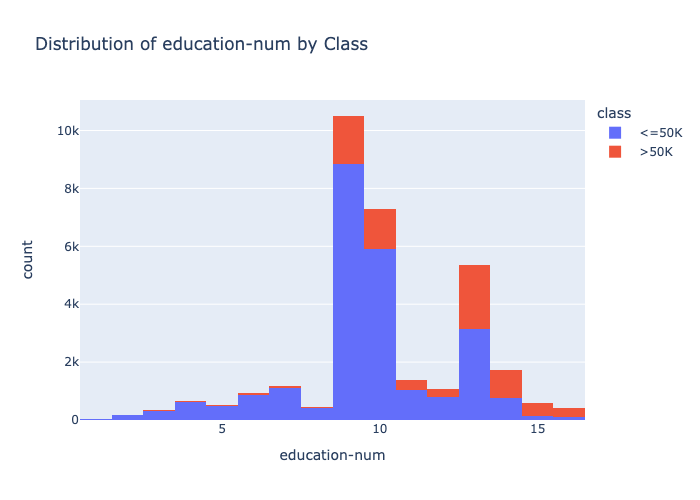

In [48]:
fig6 = px.histogram(df_train, x="education-num", color = 'class', title = "Distribution of education-num by Class")
fig6.show("png")


education-num was one of the top variables that was most correlated to class. The average number of years of education as seen in the descriptive statistics is 10 years. From this plot we can see that this company seems to have a lot of customers that have between 9-10 years of education and 13 years of education. All of these groups of people also seem to have the most amount of people who earn >50K. 

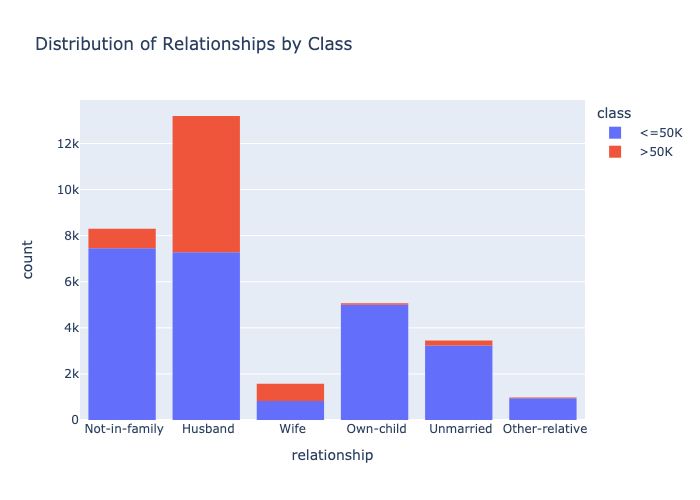

In [47]:
fig7 = px.histogram(df_train, x="relationship", color="class", title = "Distribution of Relationships by Class")
fig7.show("png")

relationship was the other variable that had a higher correlation to class. It was found earlier that there is a larger number of males in the dataset so it is no suprise that "husband" is the relationship we see with the highest count. With that being said, this gives me reason to believe that a large amount of this companies' costumers are married. 

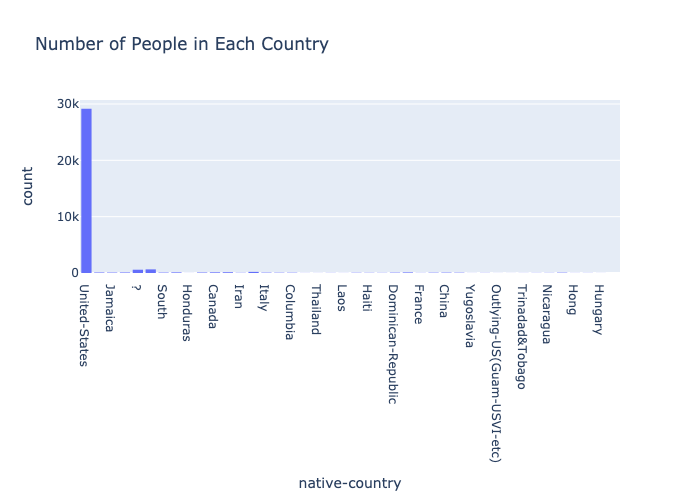

In [44]:
fig8 = px.histogram(df_train, x="native-country", title = "Number of People in Each Country")
fig8.show("png")

Just to gather more information on the client base I plotted the native-country. It is clear that the dataset is comprised largley of people from the United States. 